In [3]:
import ee
ee.Authenticate()
ee. Initialize()


Successfully saved authorization token.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [4]:
import sys
sys.path.append('C:/Users/ishaa/OneDrive/Desktop/DataLab/Syria/syria-economic-monitor/Phenolopy/scripts')
import phenolopy


In [5]:
sys.path.append('C:/Users/ishaa/OneDrive/Desktop/DataLab/Syria/syria-economic-monitor/GEE_Zonal/src/gee_zonal')  # Replace with the actual path to the GEE_Zonal repository
import gee_helpers

In [6]:
import os
from os.path import join, expanduser

#sys.path.append(join(expanduser("~"), "Repos", "GEE_Zonal", "src"))

# Data
import geopandas as gpd
import pandas as pd
import numpy as np 
import json

## Earth Engine APIs
import ee
import gee_zonal
import geemap
from gee_helpers import gpd_to_gee
#from gee_zonal import gpd_to_gee
from geemap.conversion import *

import xarray as xr
from tqdm.notebook import tqdm
from dask.distributed import Client, LocalCluster
import requests

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format


#sys.path.append(join(expanduser("~"), "Repos", "phenolopy", "scripts"))
#import phenolopy

sys.path.append(join(expanduser("~"), "Repos", "GOSTrocks", "src"))

In [7]:
base_path = "C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor"

In [6]:
start_period = ee.Date("2004-01-01")
end_period = ee.Date("2023-12-31")

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")


def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}

lgrip30 = ee.ImageCollection(
    "projects/sat-io/open-datasets/GFSAD/LGRIP30"
).mosaic()  # .clip(geoj)
crop_data = lgrip30.select("b1").gt(1).rename("crop")

# Use ESA WorldCover 2021 dataset for the crop mask
esa_worldcover = ee.ImageCollection("ESA/WorldCover/v100").mosaic()
crop_data1 = esa_worldcover.select("Map").eq(40).rename("crop")


In [7]:
iso3 = "SYR"
country = "Syria"
release_type = "gbOpen"

adm = "ADM0"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm0_syr = gpd.read_file(res["gjDownloadURL"])

adm = "ADM1"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm1_syr = gpd.read_file(res["gjDownloadURL"])

adm = "ADM2"
geo_url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3}/{adm}/"
res = requests.get(geo_url).json()
print("Reading " + res["gjDownloadURL"])
adm2_syr = gpd.read_file(res["gjDownloadURL"])


Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM0/geoBoundaries-SYR-ADM0.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM1/geoBoundaries-SYR-ADM1.geojson
Reading https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/SYR/ADM2/geoBoundaries-SYR-ADM2.geojson


In [8]:
aoi = gpd_to_gee(adm0_syr)
## considering smaller aoi geometry
#aoi1 = gpd_to_gee(adm1_syr)
#aoi2 = gpd_to_gee( adm2_syr)

In [9]:
syr_admin0_path = os.path.join(base_path,'data\\boundaries\\syr_admin0.shp')
syr_shp = gpd.read_file(syr_admin0_path)
syr_shp.to_file("syria_boundary.geojson", driver="GeoJSON")

with open("syria_boundary.geojson") as f:
    syr_geojson = json.load(f)

syr_geometry = ee.Geometry(syr_geojson['features'][0]['geometry'])

In [11]:
m = geemap.Map(center=[34.8,39.1],zoom = 6)
m.addLayer(syr_geometry,{'color':'blue'},'Syria Boundary')
m

Map(center=[34.8, 39.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:
scale_factor = 0.0001


# apply cropland mask to imageCollection
# def cropmask(img):
#   return img.clip(aoi) #.multiply(scale_factor) # unmask(-1)
def cropmask(img):
    return img.updateMask(crop_data).clip(syria_geometry)  # .multiply(scale_factor) # unmask(-1)


#mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)
mxd13q1 = modis.map(cropmask)

In [9]:
ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com")

In [15]:
utm = 'EPSG:32636'# 'EPSG:4326' #"EPSG:32632"  #'EPSG:4326' 'SR-ORG:6974' 'EPSG:23847'

In [13]:
#sample_aoi = aoi.first()

In [16]:
'''ds_all = []
scale_factor = 0.0001
years = range(2020, 2024)
months = range(1, 13)
for year in tqdm(years):
    for month in tqdm(months):
        modis_sel = modis.filter(ee.Filter.calendarRange(year, year, "year")).filter(
            ee.Filter.calendarRange(month, month, "month")
        )
        # modis_sel = mxd13q1.filterDate(f'{year}-{month}-01', f'{year}-{month+1}-01')
        ds = xr.open_dataset(
            modis_sel,
            engine="ee",
            geometry=syr_geometry,
            crs=utm,
            scale=250,
        )
        ds = ds * scale_factor
        ds = ds.compute()
        ds_all.append(ds)'''
    # print(f"Finished {year}")

'ds_all = []\nscale_factor = 0.0001\nyears = range(2020, 2024)\nmonths = range(1, 13)\nfor year in tqdm(years):\n    for month in tqdm(months):\n        modis_sel = modis.filter(ee.Filter.calendarRange(year, year, "year")).filter(\n            ee.Filter.calendarRange(month, month, "month")\n        )\n        # modis_sel = mxd13q1.filterDate(f\'{year}-{month}-01\', f\'{year}-{month+1}-01\')\n        ds = xr.open_dataset(\n            modis_sel,\n            engine="ee",\n            geometry=syr_geometry,\n            crs=utm,\n            scale=250,\n        )\n        ds = ds * scale_factor\n        ds = ds.compute()\n        ds_all.append(ds)'

In [52]:
ds = xr.concat(ds_all, dim="time")

In [53]:
print(ds)

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 184, X: 2346, Y: 2373)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2020-01-01 2020-01-09 ... 2023-12-27
  * X        (X) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * Y        (Y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
Data variables:
    EVI      (time, X, Y) float32 4GB 0.2024 0.1795 0.1724 ... 0.3423 0.2575
Attributes:
    crs:      EPSG:32636


In [54]:
#import xarray as xr

# Assuming your dataset is already loaded as 'ds'
# Total number of data points in the EVI variable
total_values = ds['EVI'].size

# Number of non-NaN values in the EVI variable
non_nan_count = ds['EVI'].notnull().sum().values

# Calculate the percentage of non-NaN values
percentage_non_nan = (non_nan_count / total_values) * 100

# Print the result
print(f"Percentage of non-NaN values in the EVI column: {percentage_non_nan:.2f}%")


Percentage of non-NaN values in the EVI column: 98.33%


In [55]:
ds = ds.isel(Y=slice(None, None, -1))

In [ ]:
for val in ds['EVI']:
    print(val.values)

In [57]:
ds.to_netcdf('C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\notebooks\\vegetation-conditions\\syr_geom_nonbit_masked_2020_2023.nc')

In [58]:
netcdf_path = 'C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\notebooks\\vegetation-conditions\\syr_geom_nonbit_masked_2020_2023.nc'
ds = xr.open_dataset(netcdf_path)  # maradi
# ds = ds.isel(time=range(0,23))

In [59]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 184, X: 2346, Y: 2373)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2020-01-01 2020-01-09 ... 2023-12-27
  * X        (X) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * Y        (Y) float64 19kB 4.172e+06 4.171e+06 ... 3.579e+06 3.579e+06
Data variables:
    EVI      (time, X, Y) float32 4GB ...
Attributes:
    crs:      EPSG:32636

In [60]:
import multiprocessing
multiprocessing.cpu_count()

8

In [62]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
# cluster = LocalCluster()
# explicitly connect to the cluster we just created
# client = Client(cluster)
# client

# Dask Prep
workers = 70  # 50
cluster = LocalCluster(n_workers=workers)
client = Client(cluster)
client

c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57326 instead


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:57326/status,
Dashboard: http://127.0.0.1:57326/status,Workers: 70
Total threads: 70,Total memory: 15.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57327,Workers: 70
Dashboard: http://127.0.0.1:57326/status,Total threads: 70
Started: 1 minute ago,Total memory: 15.37 GiB
Comm: tcp://127.0.0.1:57702,Total threads: 1
Dashboard: http://127.0.0.1:57703/status,Memory: 224.82 MiB
Nanny: tcp://127.0.0.1:57330,


In [64]:
ds_all = []
years = range(2021, 2024)  # 2001 2024
for year in tqdm(years):
    ds_sel = ds.sel(time=ds.time.dt.year == year)
    dask_chunks = {"time": -1, "X": 500, "Y": 500}
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = ds_sel.rename_vars({"EVI": "veg_index"})
    ds_sel = phenolopy.remove_outliers(
        ds=ds_sel, method="median", user_factor=2, z_pval=0.05
    )
    ds_sel = ds_sel.chunk(dask_chunks)
    ds_sel = phenolopy.interpolate(ds=ds_sel, method="interpolate_na")
    ds_sel = phenolopy.smooth(
        ds=ds_sel, method="savitsky", window_length=3, polyorder=1
    )
    ds_sel = ds_sel.compute()
    ds_all.append(ds_sel)
    print(f"Finished {year}")

  0%|          | 0/3 [00:00<?, ?it/s]

Outlier removal method: median with a user factor of: 2
> Generated roll window size is an even number, added 1 to make it odd (7).


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



KilledWorker: Attempted to run task ('moment_agg-aggregate-moment_chunk-mul-getitem-09294eb5a32a1c321521c13e5568ec3a', 0, 3, 1) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:57568. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
print(ds_all)

In [108]:
ds2 = xr.concat(ds_all, dim="time")

In [32]:
base_path = 'C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\notebooks\\vegetation-conditions'

In [109]:
# Flip the data along the y-axis
# ds2 = ds2.isel(Y=slice(None, None, -1))
ds_geo = ds2.copy()
ds_geo.rio.write_crs(utm, inplace=True)
ds_geo = ds_geo.transpose("time", "Y", "X")
ds_geo = ds_geo.rename({"Y": "y", "X": "x"})
ds_geo.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds_geo.to_zarr(join(base_path, "modis_crop_dea_processed_sampleaoi1_2017_20.zarr"))

In [8]:
ds_geo = xr.open_zarr(join(base_path,'data','modis_crop_processed.zarr'))
ds_geo

<xarray.Dataset> Size: 15GB
Dimensions:      (time: 679, y: 2373, x: 2346)
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 5kB 2010-01-01 2010-01-09 ... 2024-09-29
  * x            (x) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * y            (y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
Data variables:
    veg_index    (time, y, x) float32 15GB dask.array<chunksize=(43, 149, 147), meta=np.ndarray>

## Anomalies per Pixel

In [9]:
ds_monthly = ds_geo.resample(time="1ME").mean()

In [10]:
start_reference = "2015-01-01"
end_reference = "2022-12-31"

In [12]:
ds_ref = ds_monthly.sel(time=slice(None, end_reference))  # ds_geo
ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year == 2024)

ds_2024_03 = ds_filt.sel(time=ds_filt.time.dt.month == 3).isel(time=0)
ds_ref_01_mean = ds_ref.sel(time=ds_ref.time.dt.month == 3).mean(dim="time")
ds_ref_01_sdt = ds_ref.sel(time=ds_ref.time.dt.month == 3).std(dim="time")

ds_diff = ds_2024_03 - ds_ref_01_mean
ds_zscore = ds_diff / ds_ref_01_sdt

In [13]:
ds_zscore = ds_zscore.compute()

c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\array\numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\core.py:127: RuntimeWarning: divide by zero encountered in divide


In [14]:
print(ds_zscore)

<xarray.Dataset> Size: 22MB
Dimensions:      (x: 2346, y: 2373)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * y            (y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
    time         datetime64[ns] 8B 2024-03-31
Data variables:
    veg_index    (y, x) float32 22MB 1.253 1.404 1.438 ... 0.53 -0.3536 0.6749


In [15]:
ds_zscore["veg_index"].rio.write_nodata(np.nan, inplace=True)
#ds_zscore["veg_index"].rio.to_raster("C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\docs\\images\\zcore_2024_03.tif")

<xarray.DataArray 'veg_index' (y: 2373, x: 2346)> Size: 22MB
array([[ 1.2533334 ,  1.4040579 ,  1.4384341 , ...,  0.27186257,
         0.12117907,  0.27838302],
       [ 1.3956325 ,  1.221415  ,  1.283778  , ...,  0.10186512,
         0.20567566,  0.0788373 ],
       [ 1.4976697 ,  2.232562  ,  1.6762264 , ...,  0.12162127,
         0.15578163,  0.13805972],
       ...,
       [ 0.8928718 ,  0.8537426 , -0.60891753, ...,  0.5638782 ,
         0.6867019 ,  1.3231986 ],
       [ 0.4243074 ,  0.3947235 ,  0.48470438, ..., -0.08130699,
        -0.3322379 ,  1.8377289 ],
       [ 0.5394801 ,  0.6550329 ,  0.5776956 , ...,  0.53002805,
        -0.35355255,  0.6748626 ]], dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * y            (y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
    time         datetime64[ns] 8B 2024-03-31
Attributes:
    _FillValue:  nan

In [15]:
import numpy as np

# Define the range of years
start_year = 2015
end_year = 2024

# Loop through each year
for year in range(start_year, end_year + 1):  # Include 2024
    # Filter data for the current year (March)
    ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year == year)
    ds_current_month = ds_filt.sel(time=ds_filt.time.dt.month == 3).isel(time=0)

    # Calculate the reference mean and standard deviation for March
    ds_ref_01_mean = ds_ref.sel(time=ds_ref.time.dt.month == 3).mean(dim="time")
    ds_ref_01_std = ds_ref.sel(time=ds_ref.time.dt.month == 3).std(dim="time")

    # Calculate the z-score
    ds_diff = ds_current_month - ds_ref_01_mean
    ds_zscore = ds_diff / ds_ref_01_std

    # Compute the dataset (if it's lazy-loaded)
    ds_zscore = ds_zscore.compute()

    # Write the z-score to a GeoTIFF
    output_path = f"C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor\\docs\\images\\zscore_{year}_03.tif"
    ds_zscore["veg_index"].rio.write_nodata(np.nan, inplace=True)
    ds_zscore["veg_index"].rio.to_raster(output_path)

    print(f"Z-score raster for March {year} saved to: {output_path}")


c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\array\numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\array\numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\array\numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\dask\array\numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
c:\Users\ishaa\anaconda3\Anacon

Z-score raster for March 2015 saved to: C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\docs\images\zscore_2015_03.tif
Z-score raster for March 2016 saved to: C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\docs\images\zscore_2016_03.tif
Z-score raster for March 2017 saved to: C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\docs\images\zscore_2017_03.tif
Z-score raster for March 2018 saved to: C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\docs\images\zscore_2018_03.tif
Z-score raster for March 2019 saved to: C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\docs\images\zscore_2019_03.tif
Z-score raster for March 2020 saved to: C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\docs\images\zscore_2020_03.tif
Z-score raster for March 2021 saved to: C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\docs\images\zscore_2021_03.tif
Z-score raster for M

In [23]:
# import leafmap
import leafmap.foliumap as leafmap

import rasterio
import xarray as xr

In [20]:
url1 = "https://open.gishub.org/data/raster/landsat.tif"
url2 = "https://open.gishub.org/data/raster/srtm90.tif"
satellite = leafmap.download_file(url1, "landsat.tif", overwrite=True)
dem = leafmap.download_file(url2, "srtm90.tif")

Downloading...
From: https://open.gishub.org/data/raster/landsat.tif
To: c:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\notebooks\vegetation-conditions\landsat.tif
100%|██████████| 10.1M/10.1M [00:00<00:00, 30.5MB/s]

srtm90.tif already exists. Skip downloading. Set overwrite=True to overwrite.


In [21]:
dataset = rasterio.open(satellite)
nir = dataset.read(4).astype(float)
red = dataset.read(1).astype(float)
ndvi = (nir - red) / (nir + red)

In [22]:
ndvi_image = leafmap.array_to_image(ndvi, source=satellite)

In [23]:
ndvi_image.profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2127, 'height': 1564, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(180.0, 0.0, -13442580.0,
       0.0, -180.0, 4670100.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [24]:
import localtileserver
print(localtileserver.Report())


--------------------------------------------------------------------------------
  Date: Tue Nov 05 11:05:34 2024 Eastern Standard Time

                OS : Windows (10 10.0.22631 SP0 Multiprocessor Free)
            CPU(s) : 8
           Machine : AMD64
      Architecture : 64bit
               RAM : 15.4 GiB
       Environment : Jupyter

  Python 3.9.20 | packaged by conda-forge | (main, Sep 30 2024, 17:43:23) [MSC
  v.1929 64 bit (AMD64)]

   localtileserver : 0.10.4
             click : 8.1.7
             flask : 3.0.3
     flask_caching : 2.3.0
        flask_cors : 5.0.0
       flask_restx : 1.3.0
             numpy : 2.0.2
          rasterio : 1.4.1
         rio_cogeo : 5.3.6
         rio_tiler : 6.7.0
     server_thread : 0.2.0
          werkzeug : 3.0.4
            folium : 0.17.0
        ipyleaflet : 0.19.2
        jupyterlab : 4.2.5
        matplotlib : 3.9.2
           shapely : 2.0.6
         traitlets : 5.14.3
-------------------------------------------------------------

In [ ]:
m = leafmap.Map()
m.add_raster(satellite, indexes=[4, 1, 2], vmin=0, vmax=120, layer_name="Landsat 7")
m.add_raster(ndvi_image, colormap="Greens", layer_name="NDVI")
m

[2024-11-05 11:05:42,209] ERROR in app: Exception on /api/tiles/8/42/99.png [GET]
Traceback (most recent call last):
  File "c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\flask\app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
  File "c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\flask_restx\api.py", line 402, in wrapper
    resp = resource(*args, **kwargs)
  File "c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\flask\views.py", line 110, in view
    return current_app.ensure_sync(self.dispatch_request)(**kwargs)  # type: ignore[no-any-return]
  File "c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\flask_restx\resource.py", line 41, in dispatch_request
    resp = meth(*args, **kwargs)
 

In [24]:
ds_ref = ds_monthly.sel(time=slice(None, end_reference)) # ds_geo
ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year==2023)
ds_2023_07 = ds_filt.sel(time=ds_filt.time.dt.month==7).isel(time=0)
ds_ref_07 = ds_ref.sel(time=ds_ref.time.dt.month==7).mean(dim='time')
ds_diff = ds_2023_07 - ds_ref_07
ds_pct_ch = (ds_diff / ds_ref_07)

In [25]:
ds_pct_ch = ds_pct_ch.compute()

In [28]:
ds_pct_ch['veg_index'].rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'veg_index' (y: 2373, x: 2346)> Size: 22MB
array([[-0.05527501, -0.05515949, -0.06892604, ..., -0.04208269,
        -0.05072116, -0.04514556],
       [-0.06310175, -0.08038745, -0.02294717, ..., -0.04504818,
        -0.04972969, -0.0438232 ],
       [-0.05126707, -0.0611834 , -0.10293785, ..., -0.04326151,
        -0.03819561, -0.02639454],
       ...,
       [ 0.07421084, -0.09834372, -0.13562185, ...,  0.00024571,
         0.01478369, -0.03796959],
       [ 0.02043971,  0.01193917, -0.05656576, ...,  0.0214442 ,
        -0.04511974, -0.06558742],
       [ 0.05058417,  0.00013864, -0.01372366, ..., -0.08111423,
        -0.05479483, -0.10614654]], dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 19kB 7.462e+05 7.465e+05 ... 1.332e+06 1.332e+06
  * y            (y) float64 19kB 3.579e+06 3.579e+06 ... 4.171e+06 4.172e+06
    time         datetime64[ns] 8B 2023-07-31
Attributes:
    _FillValue:  nan

In [26]:
ds_pct_ch['veg_index'].rio.to_raster(join(base_path, 'pct_ch_2018_09.tif'))

In [27]:
da = ds_pct_ch["veg_index"]

In [28]:
'''m = leafmap.Map()
m.add_raster(da, colormap="BrBG", layer_name="VEG Index")
m.add_raster(dem, colormap="terrain", layer_name="DEM")
m.add_raster(masked_array, colormap="coolwarm", layer_name="Classified DEM")
m'''

'm = leafmap.Map()\nm.add_raster(da, colormap="BrBG", layer_name="VEG Index")\nm.add_raster(dem, colormap="terrain", layer_name="DEM")\nm.add_raster(masked_array, colormap="coolwarm", layer_name="Classified DEM")\nm'

In [29]:
ds_pct_ch["veg_index"].max()


<xarray.DataArray 'veg_index' ()> Size: 8B
array(63176.26171875)
Coordinates:
    spatial_ref  int64 8B 0
    time         datetime64[ns] 8B 2023-07-31

## Summary of Anomalies

In [16]:
# data = ds_pct_ch['veg_index'].values
data = ds_zscore["veg_index"].values
data = data[~np.isnan(data)]

In [18]:
data = data[~np.isnan(data)]

In [19]:
# bins = np.linspace(-0.5, 0.5, 21)
# bins = range(-5, 5, 1)
# bins = np.linspace(-3, 3, 13)
bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
bin_labels = [
    "< -2",
    "(-2, -1]",
    "(-1, -0.5]",
    "(-0.5, -0.5]",
    "(0.5, 1]",
    "(1, 2]",
    "> 2",
]
bins

[-20, -2, -1, -0.5, 0.5, 1, 2, 20]

In [20]:
import matplotlib.pyplot as plt

In [21]:
vals, bins = np.histogram(data, bins=bins)
df = pd.DataFrame({"vals": vals, "bins": bins[:-1]})

In [22]:
df

,vals,bins
0,15528,-20.0
1,134257,-2.0
2,579782,-1.0
3,2104318,-0.5
4,931049,0.5
5,1178586,1.0
6,533851,2.0


<Axes: xlabel='bins'>

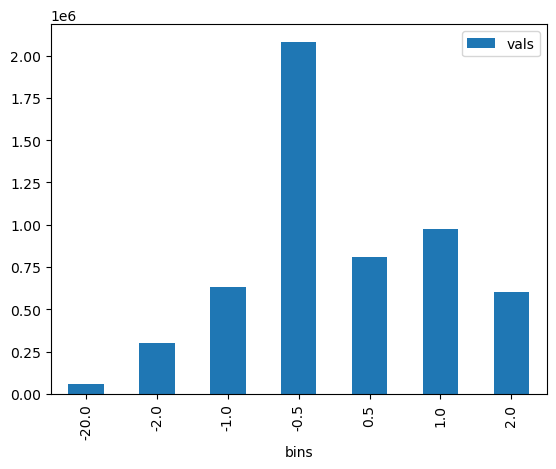

In [35]:
fig, ax = plt.subplots()
df.plot(kind="bar", x="bins", y="vals", ax=ax)

In [23]:
bins = [-20, -2, -1, -0.5, 0.5, 1, 2, 20]
bin_labels = [
    "< -2",
    "(-2, -1]",
    "(-1, -0.5]",
    "(-0.5, -0.5]",
    "(0.5, 1]",
    "(1, 2]",
    "> 2",
]

df = pd.DataFrame(data, columns=["zscore"])
df.loc[:, "zscore_bin"] = pd.cut(
    data, bins=bins, include_lowest=True, labels=bin_labels
)
df2 = df["zscore_bin"].value_counts().sort_index()
df2 = pd.DataFrame(df2).reset_index()
df2.loc[:, "pct"] = df2["count"] / df2["count"].sum()

In [24]:
font = "Liberation Sans"

In [25]:
df2

,zscore_bin,count,pct
0,< -2,15528,0.002835
1,"(-2, -1]",134257,0.024511
2,"(-1, -0.5]",579782,0.105850
3,"(-0.5, -0.5]",2104318,0.384184
4,"(0.5, 1]",931049,0.169981
5,"(1, 2]",1178587,0.215174
6,> 2,533850,0.097465


In [26]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
from mizani.formatters import percent_format

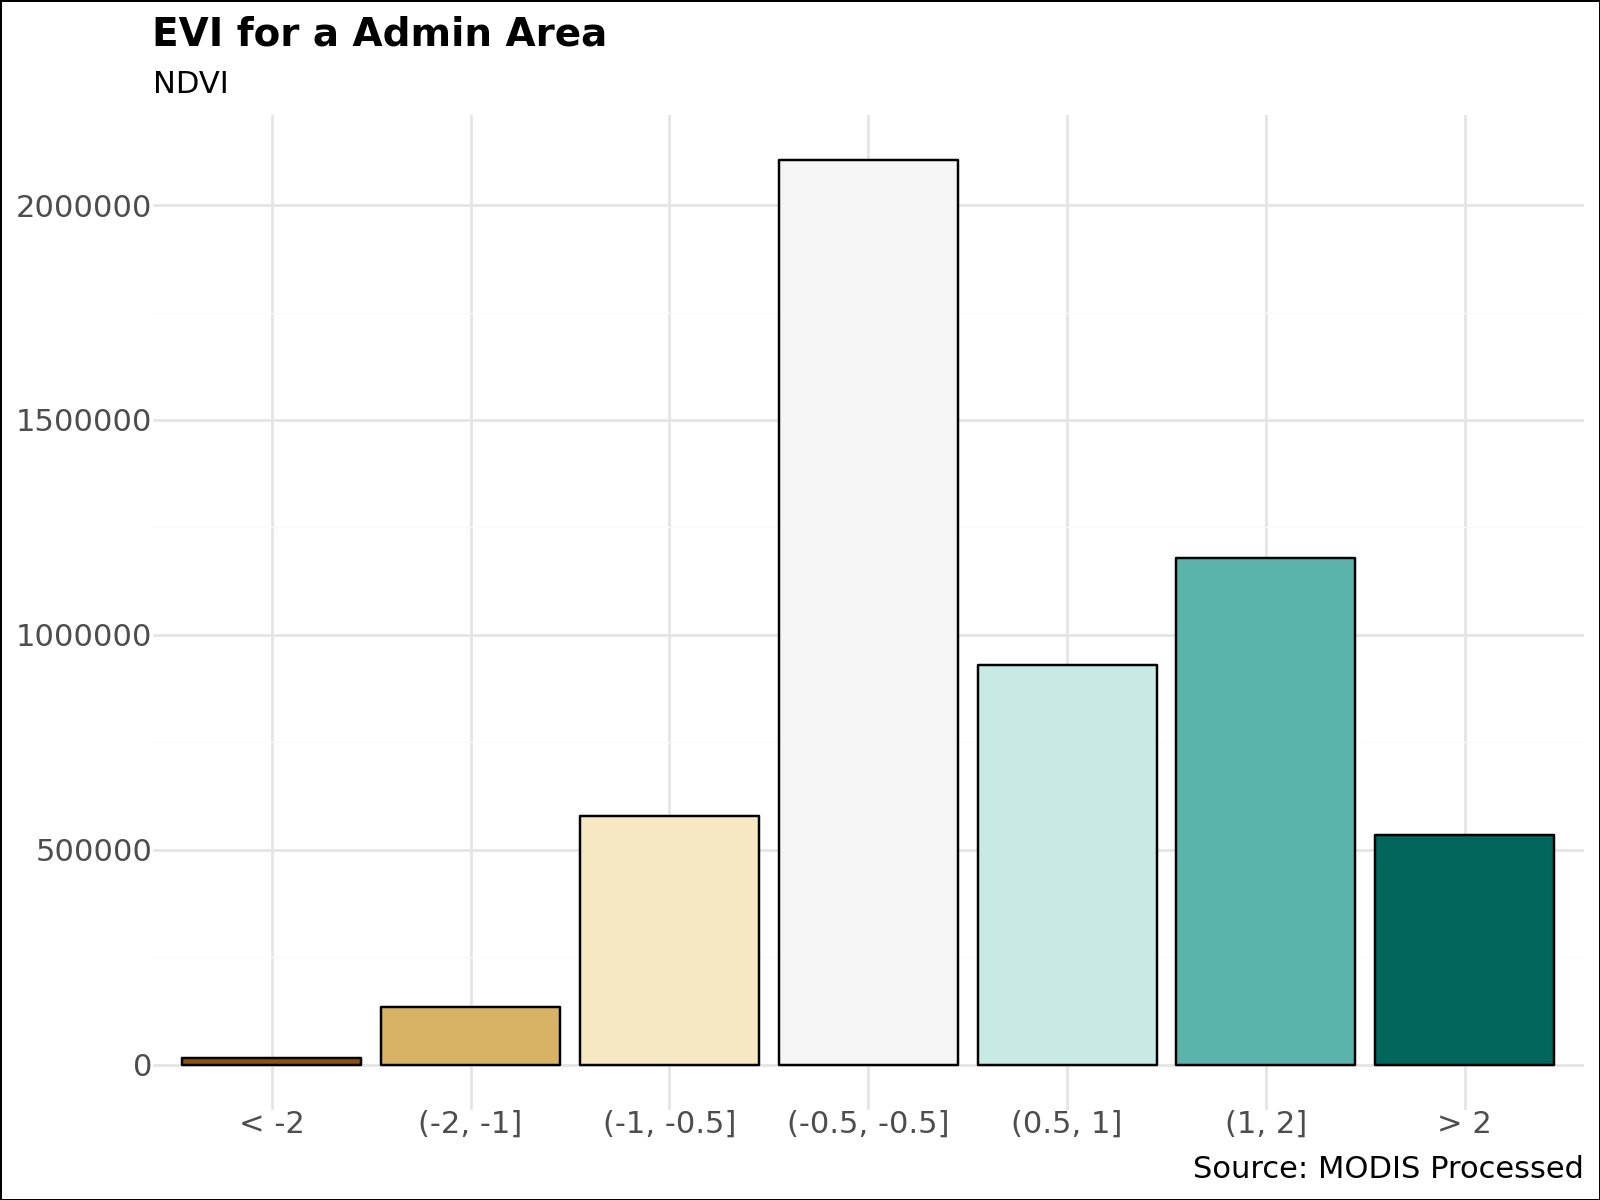

In [27]:
# fig, ax = plt.subplots()

(
    ggplot(df2, aes(x="zscore_bin", y="count", fill="zscore_bin"))
    + geom_bar(alpha=1, stat="identity", color="black")  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

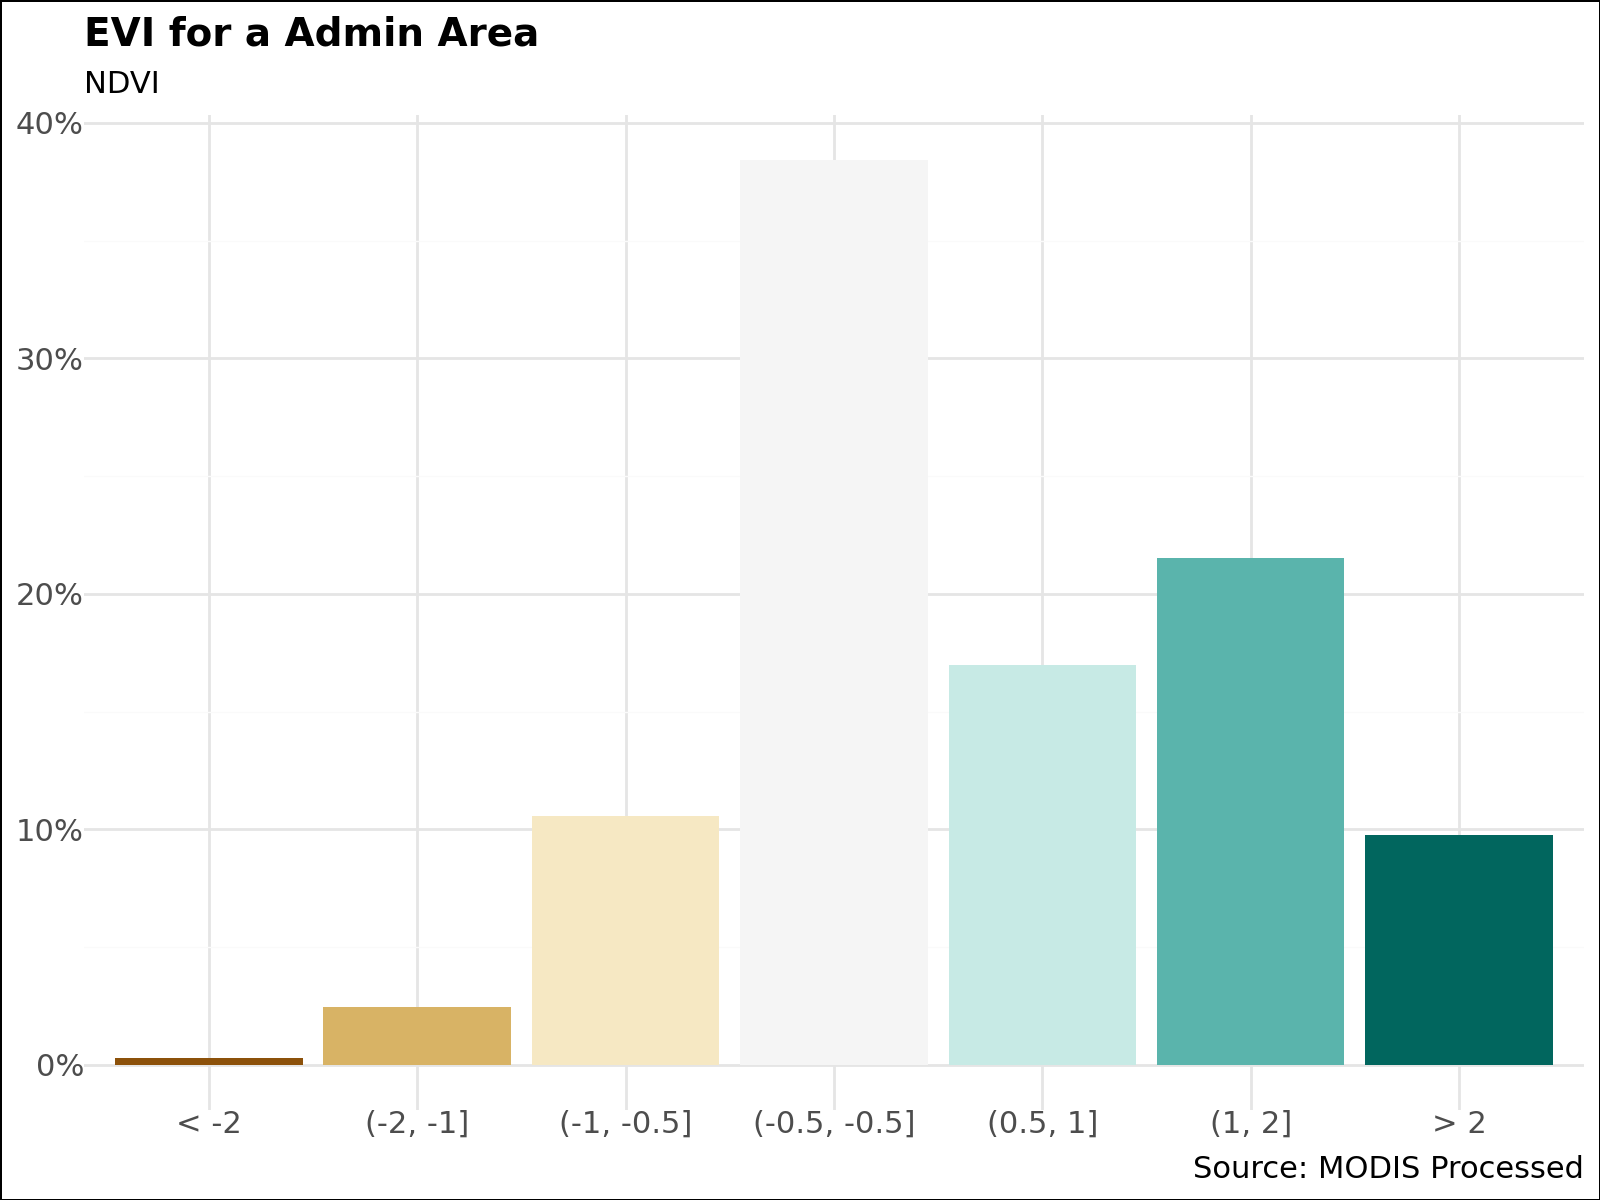

In [28]:
# fig, ax = plt.subplots()

(
    ggplot(df2, aes(x="zscore_bin", y="pct", fill="zscore_bin"))
    + geom_bar(alpha=1, stat="identity")  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

In [29]:
bins = [-20, -1, 1, 20]
bin_labels = ["< -1", "(-1, 1]", "> 1"]

df = pd.DataFrame(data, columns=["zscore"])
df.loc[:, "zscore_bin"] = pd.cut(
    data, bins=bins, include_lowest=True, labels=bin_labels
)
df2 = df["zscore_bin"].value_counts().sort_index()
df2 = pd.DataFrame(df2).reset_index()
df2.loc[:, "pct"] = df2["count"] / df2["count"].sum()

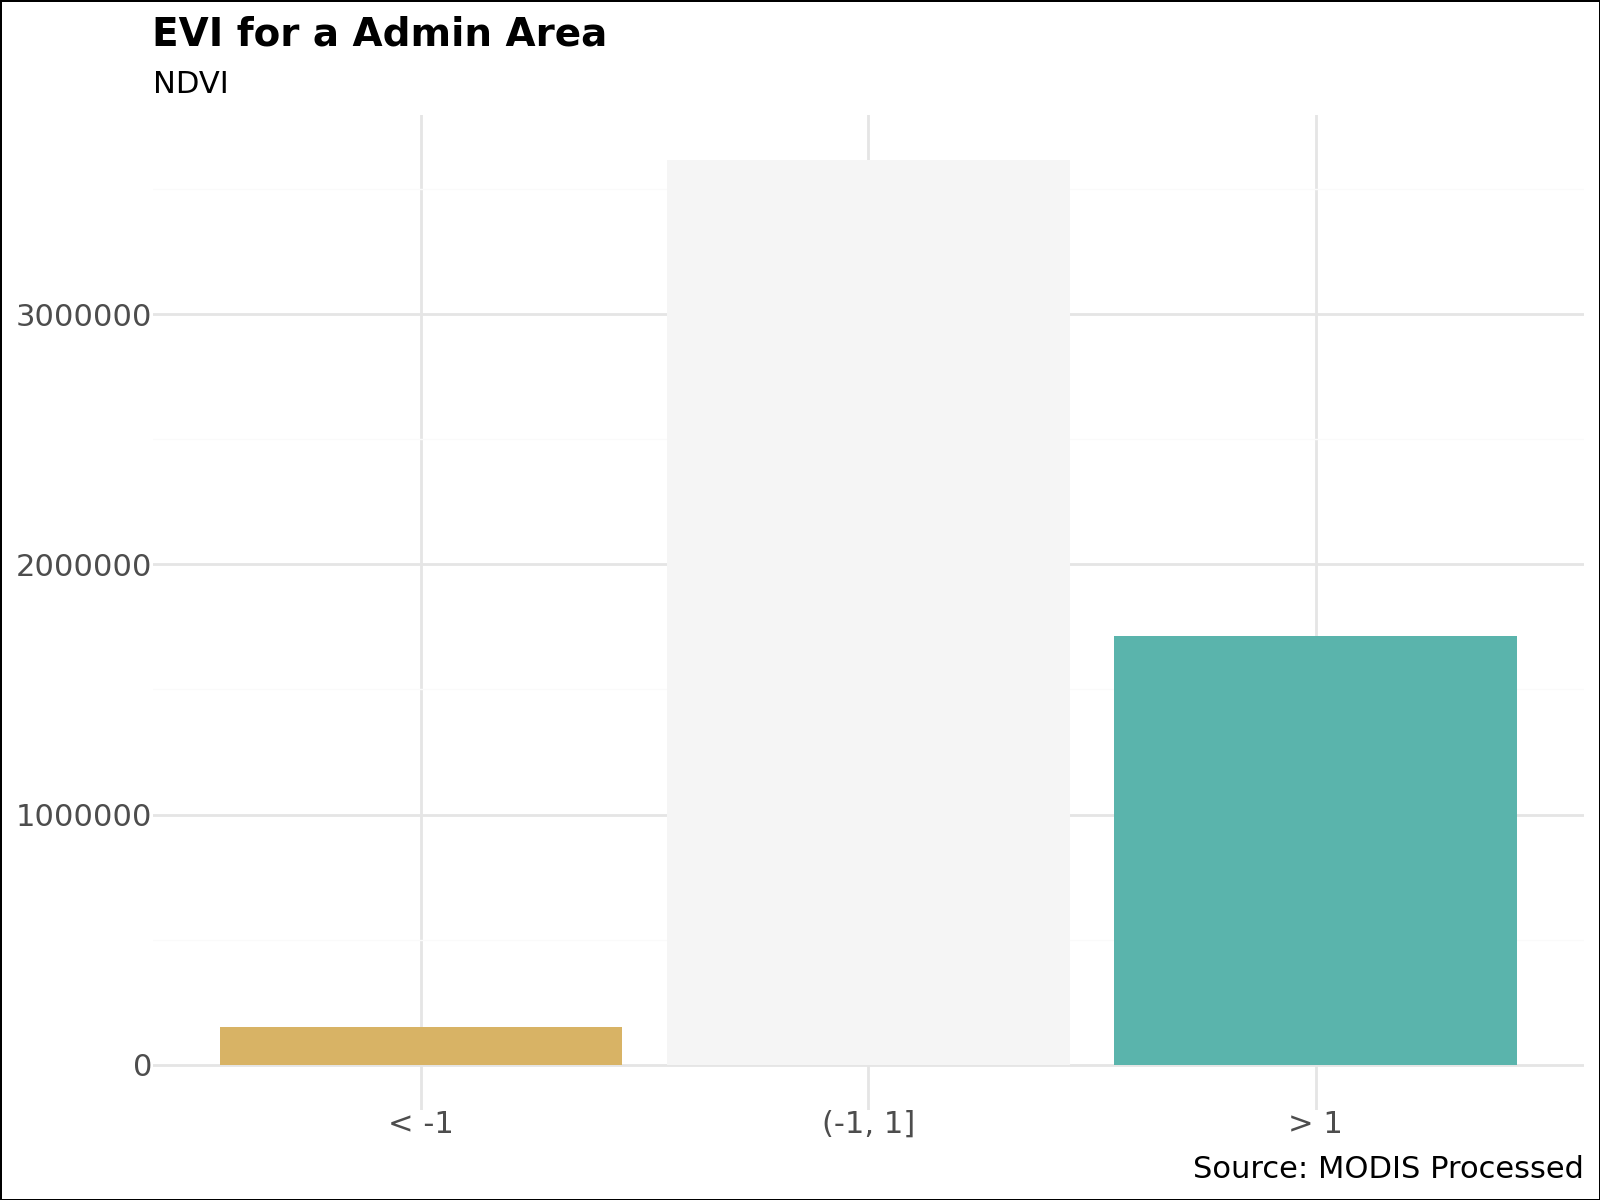

In [30]:
# fig, ax = plt.subplots()

(
    ggplot(df2, aes(x="zscore_bin", y="count", fill="zscore_bin"))
    + geom_bar(alpha=1, stat="identity")  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

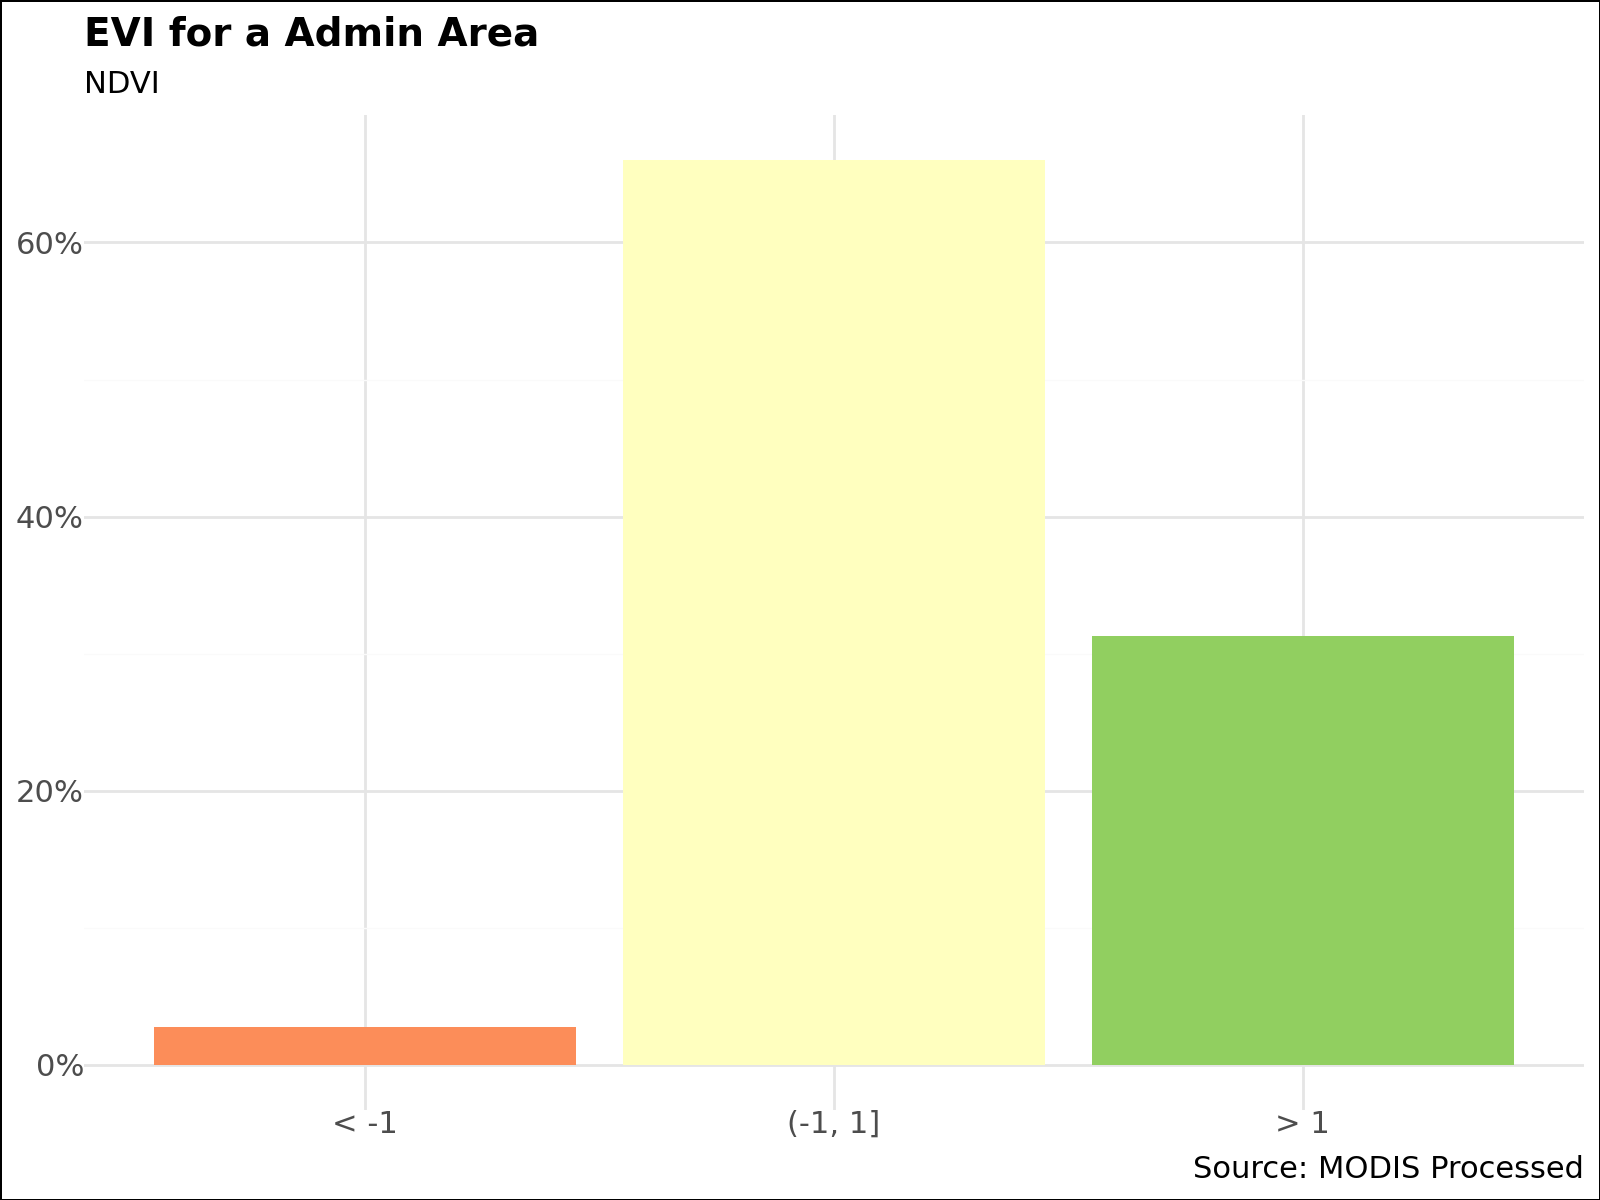

In [31]:
# fig, ax = plt.subplots()

(
    ggplot(df2, aes(x="zscore_bin", y="pct", fill="zscore_bin"))
    + geom_bar(alpha=1, stat="identity")  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

In [32]:
fig, ax = plt.subplots()
df["zscore_bin"].value_counts().sort_index().plot(kind="bar", ax=ax)

<Axes: xlabel='zscore_bin'>

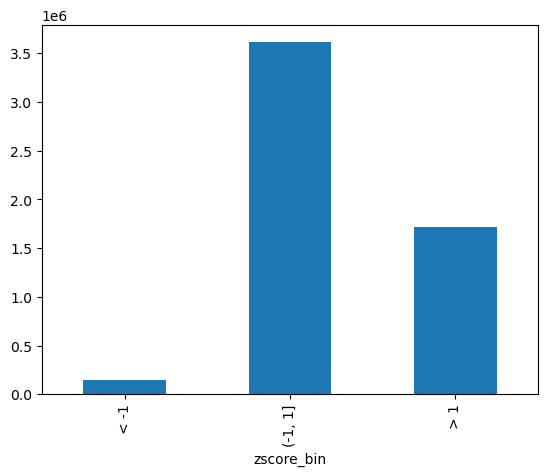

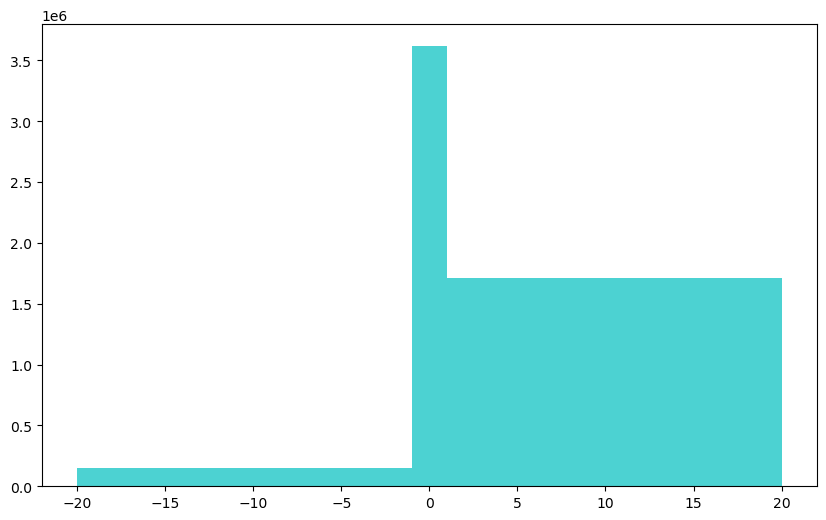

In [33]:
# # make a histogram plot of the data
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(data, bins=bins, color="c", alpha=0.7)
plt.show()

## Loop Years

In [34]:
start_reference = "2015-01-01"
end_reference = "2022-01-01"
# end_reference = "2014-01-01"

In [35]:
ds_ref = ds_monthly.sel(time=slice(None, end_reference))  # ds_geo
ds_ref_09_mean = ds_ref.sel(time=ds_ref.time.dt.month == 3).mean(dim="time")
ds_ref_09_sdt = ds_ref.sel(time=ds_ref.time.dt.month == 3).std(dim="time")


# ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year==2023)
# ds_2023_09 = ds_filt.sel(time=ds_filt.time.dt.month==9).isel(time=0)
# ds_diff = ds_2023_09 - ds_ref_09_mean
# ds_zscore = (ds_diff / ds_ref_09_sdt)

In [37]:
res = []
years = range(2014, 2025)
for year in tqdm(years):
    print(f"Calc anomalies for {year}")
    ds_filt = ds_monthly.sel(time=ds_monthly.time.dt.year == year)
    ds_filt_09 = ds_filt.sel(time=ds_filt.time.dt.month == 9).isel(time=0)
    ds_diff = ds_filt_09 - ds_ref_09_mean
    ds_zscore = ds_diff / ds_ref_09_sdt
    ds_zscore = ds_zscore.compute()
    ds_zscore["veg_index"].rio.write_nodata(np.nan, inplace=True)
    ds_zscore["veg_index"].rio.to_raster(os.path.join(base_path,'docs','images',f"zcore_dea_{year}_09.tif"))
    data = ds_zscore["veg_index"].values
    data = data[~np.isnan(data)]
    res.append(data)

  0%|          | 0/11 [00:00<?, ?it/s]

Calc anomalies for 2014
Calc anomalies for 2015
Calc anomalies for 2016
Calc anomalies for 2017
Calc anomalies for 2018
Calc anomalies for 2019
Calc anomalies for 2020
Calc anomalies for 2021
Calc anomalies for 2022
Calc anomalies for 2023
Calc anomalies for 2024


In [38]:
[len(r) for r in res]

[5451937,
 5411350,
 5473598,
 5454495,
 5476184,
 5477700,
 5455604,
 5409735,
 5431252,
 5453834,
 5475770]

In [39]:
bins = [-20, -2, -1, 1, 2, 20]
bin_labels = ["< -2", "(-2, -1]", "(-1, 1]", "(1, 2]", "> 2"]

In [40]:
res2 = []
for i, year in enumerate(years):
    data = res[i]
    df = pd.DataFrame(data, columns=["zscore"])
    df.loc[:, "zscore_bin"] = pd.cut(
        data, bins=bins, include_lowest=True, labels=bin_labels
    )
    df = df["zscore_bin"].value_counts().sort_index()
    df = pd.DataFrame(df).reset_index()
    df.loc[:, "pct"] = df["count"] / df["count"].sum()
    df.loc[:, "year"] = year
    # df.rename(columns={'count':f'count_{year}', 'pct': f'pct_{year}'}, inplace=True)
    res2.append(df)

In [41]:
df = pd.concat(res2, axis=0)

In [42]:
df

,zscore_bin,count,pct,year
0,< -2,1102138,0.202170,2014
1,"(-2, -1]",1122228,0.205855,2014
2,"(-1, 1]",3089821,0.566780,2014
3,"(1, 2]",74260,0.013622,2014
4,> 2,63086,0.011572,2014
0,< -2,1158100,0.214030,2015
1,"(-2, -1]",1383236,0.255638,2015
2,"(-1, 1]",2750708,0.508362,2015
3,"(1, 2]",63311,0.011701,2015
4,> 2,55571,0.010270,2015


In [43]:
df.loc[:, "zscore_bin_cat"] = pd.Categorical(
    df["zscore_bin"], categories=bin_labels, ordered=True
)

In [44]:
df.zscore_bin_cat.value_counts()

zscore_bin_cat
< -2        11
(-2, -1]    11
(-1, 1]     11
(1, 2]      11
> 2         11
Name: count, dtype: int64

In [45]:
font = "Liberation Sans"

In [46]:
df.head()

,zscore_bin,count,pct,year,zscore_bin_cat
0,< -2,1102138,0.202170,2014,< -2
1,"(-2, -1]",1122228,0.205855,2014,"(-2, -1]"
2,"(-1, 1]",3089821,0.566780,2014,"(-1, 1]"
3,"(1, 2]",74260,0.013622,2014,"(1, 2]"
4,> 2,63086,0.011572,2014,> 2


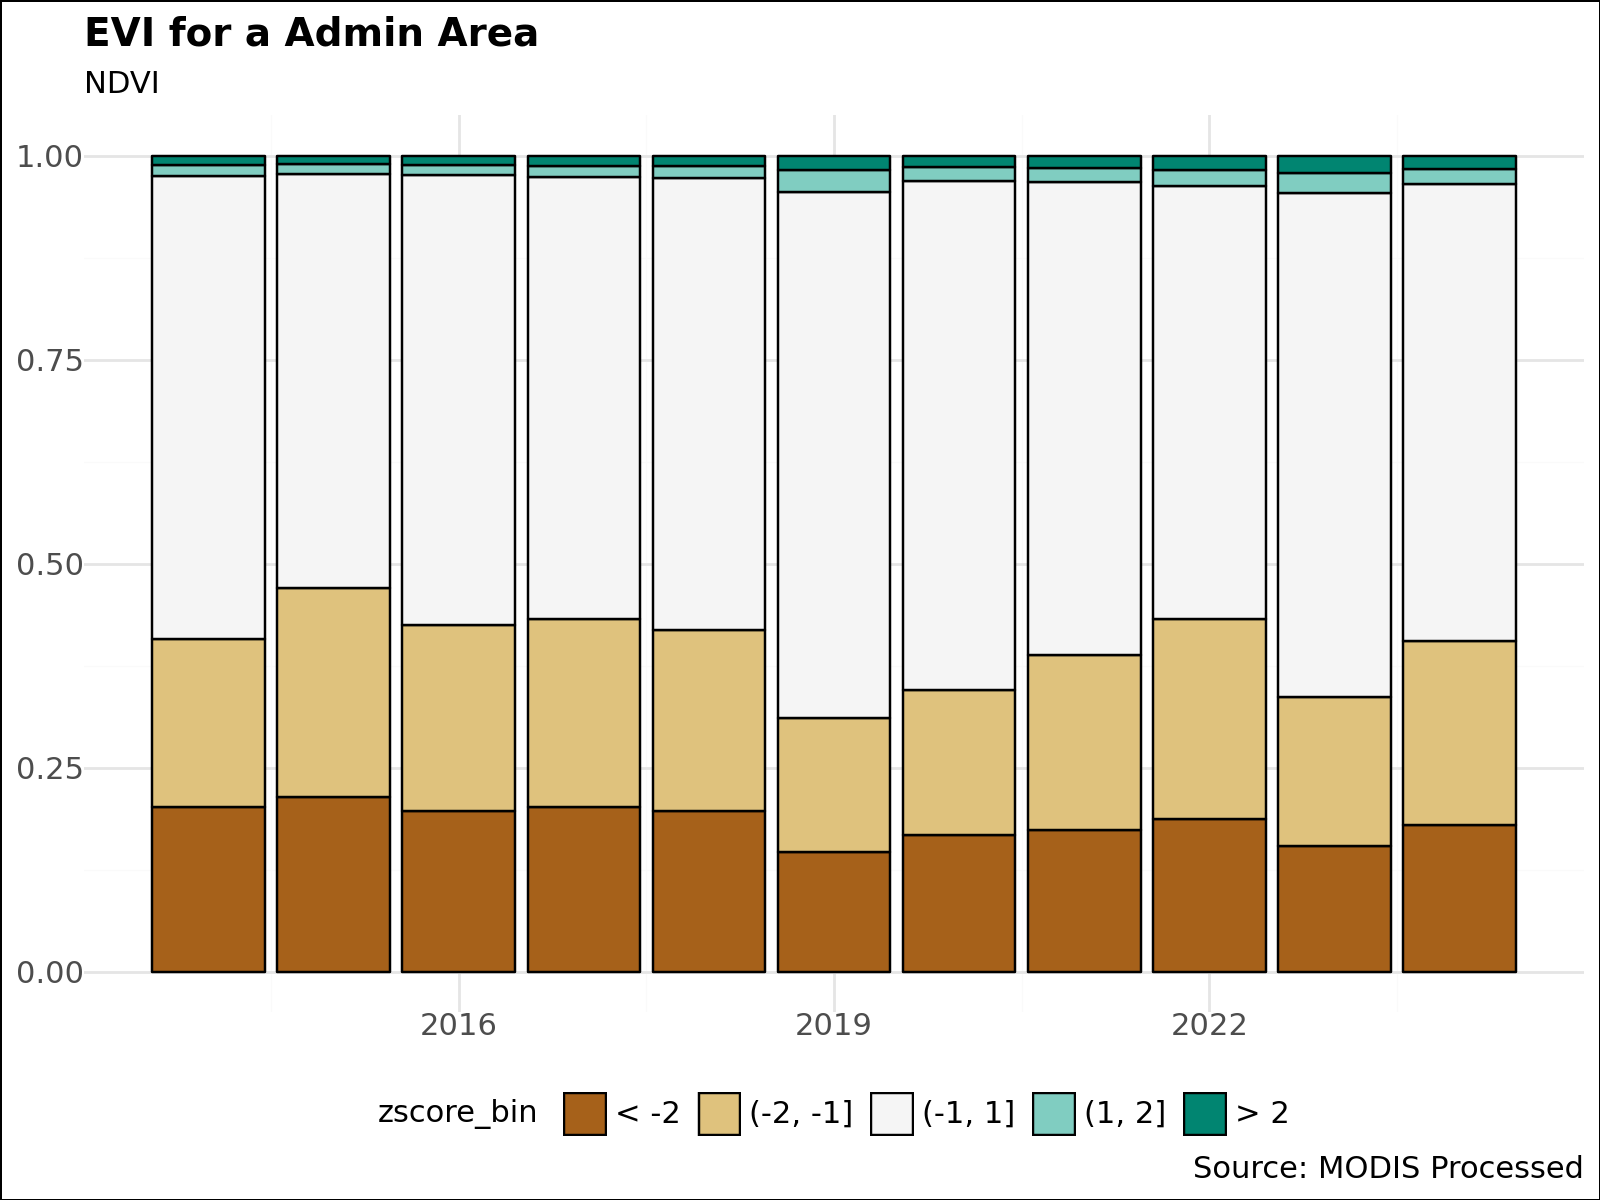

In [47]:
# fig, ax = plt.subplots()
(
    ggplot(df, aes(x="year", y="pct", fill="zscore_bin"))
    + geom_bar(
        alpha=1, stat="identity", color="black", position=position_fill(reverse=True)
    )  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position="bottom")
)

In [62]:
#charts_dir = join(expanduser("~"), "Repos", "niger")

### Evi Anomalies Chart

In [48]:
# fig, ax = plt.subplots()
p = (
    ggplot(df, aes(x="year", y="pct", fill="zscore_bin"))
    + geom_bar(
        alpha=1,
        stat="identity",
        color="black",
        width=0.5,
        position=position_fill(reverse=True),
    )  #  fill='#006d2c'
    + labs(
        x="",
        subtitle="% of Crop Area",
        title="Anomalies in Agricultural Productivity (EVI)",
        y="",
        caption="Source: MODIS Terra and Aqua",
        fill="Z-Score",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        # axis_text_x=element_text(rotation=45),
        legend_position="bottom",
    )
    + scale_fill_brewer(type="div", palette="BrBG", direction=1)
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + scale_x_continuous(breaks=range(2014, 2024))
    # + scale_fill_brewer(type='div', palette="RdYlGn", direction=1)
    # + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%m"))
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)
# p
p.save(
    filename=os.path.join(base_path, 'docs','images',"evi-anomalies-pct.jpeg"),
    dpi=300,
)

c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
c:\Users\ishaa\anaconda3\Anaconda\envs\GIS\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor\docs\images\evi-anomalies-pct.jpeg


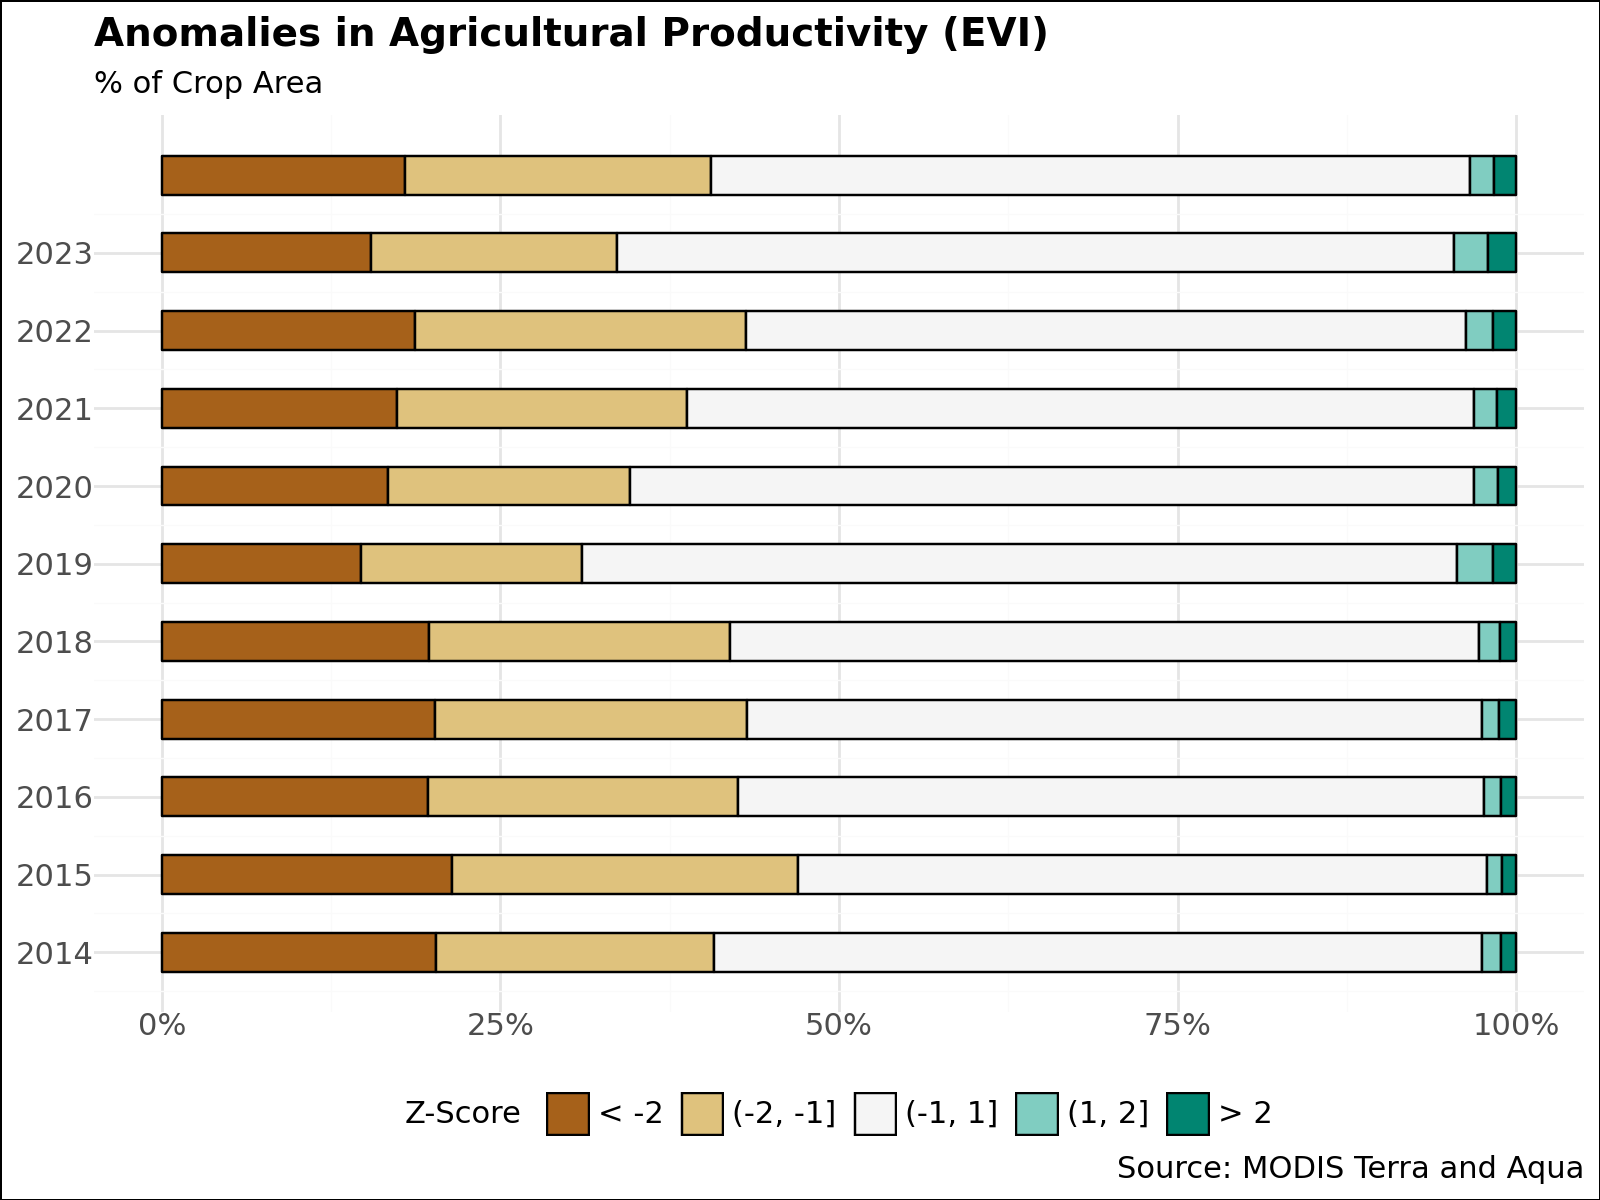

In [49]:
p

## Zonal Stats

In [52]:
a = ds_geo.rio.transform()
a

Affine(250.0, 0.0, 746085.6458245488,
       0.0, 250.0, 3578514.027071586)

In [53]:
adm1_syr_v2 = gpd.read_file(os.path.join(base_path,'data','boundaries',"syr_admin1.shp"))

In [54]:
adm1_syr_v2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [55]:
utm = "EPSG:32636"  # 'EPSG:4326' 'SR-ORG:6974' 'EPSG:23847'
# adm_df = adm0_ner.copy()
adm_df = adm1_syr_v2.copy()
adm_df = adm_df.to_crs(utm)

In [56]:
adm_df

,NAME_EN,NAM_EN_REF,NAME_AR,PCODE,ADM0_EN,ADM0_AR,ADM0_PCODE,UPDATE_DAT,geometry
0,Damascus,Damascus,دمشق,SY01,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((798252.01 3715581.667, 798308.258 37..."
1,Aleppo,Aleppo,حلب,SY02,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((972012.692 4097666.236, 973378.335 4..."
2,Rural Damascus,Rural Damascus,ريف دمشق,SY03,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((849496.959 3795451.996, 849467.528 3..."
3,Homs,Homs,حمص,SY04,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((1033648.683 3930054.458, 1057905.489..."
4,Hama,Hama,حماة,SY05,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((802124.877 3961012.669, 802576.439 3..."
5,Lattakia,Lattakia,اللاذقية,SY06,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((772731.703 3979796.61, 772690.451 39..."
6,Idleb,Idleb,إدلب,SY07,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((837164.281 4026535.895, 837353.08 40..."
7,Al-Hasakeh,Al-Hasakeh,الحسكة,SY08,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((1318933.01 4165697.276, 1318949.397 ..."
8,Deir-ez-Zor,Deir-ez-Zor,دير الزور,SY09,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"POLYGON ((1164820.976 4002272.629, 1166000.5 4..."
9,Tartous,Tartous,طرطوس,SY10,Syrian Arab Republic,الجمهورية العربية السورية,SY,2016-09-05,"MULTIPOLYGON (((761265.295 3861143.741, 761437..."


In [57]:
data

array([ 0.32647833,  0.3396697 ,  0.45478517, ..., -0.22023626,
       -0.3309476 , -0.04114509], dtype=float32)

In [58]:
a


Affine(250.0, 0.0, 746085.6458245488,
       0.0, 250.0, 3578514.027071586)

In [59]:
# res = []
var = "evi"
for date in tqdm(ds_geo.time.values):
    date = pd.to_datetime(date).strftime("%Y%m%d")
    ds_sel = ds_geo.sel(time=date)
    data = ds_sel["veg_index"].values
    zs = pd.DataFrame(
        zonal_stats(
            adm_df,
            data,
            affine=a,
            stats=["median"],
            nodata=np.nan,  #  'median', 'std', 'count'
        ),
        index=adm_df.index,
    ).rename(columns={"median": f"{var}-median_{date}"})
    adm_df = adm_df.join(zs)
    # .rename(columns={'mean':'mean_'+str(date), 'median':'median_'+str(date), 'std':'std_'+str(date), 'count':'count_'+str(date)})
    # res.append(zs)

  0%|          | 0/679 [00:00<?, ?it/s]

The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input raster must be an ee.Image.
The input ra

In [60]:
df_re = pd.wide_to_long(
    adm_df,
    stubnames=["evi-median"],
    i="NAME_EN",  # ShapeName
    j="ymd",
    sep="_",
)

In [61]:
df_re

,,NAM_EN_REF,NAME_AR,PCODE,ADM0_EN,ADM0_AR,ADM0_PCODE,UPDATE_DAT,geometry,evi-median
NAME_EN,ymd,,,,,,,,,


In [77]:
df_re.reset_index(inplace=True)
df_re.drop(columns=["geometry"], inplace=True)
df_re.to_csv(os.path.join(base_path,'data',"modis_crop_lgrip_syria_adm1_v2.csv"), index=False)

### Load Table

In [62]:
df_re = pd.read_csv(os.path.join(base_path, 'data', "modis_crop_lgrip_syria_adm1_v2.csv"))

In [63]:
df_re.head(5)

,NAME_EN,ymd,NAM_EN_REF,NAME_AR,PCODE,ADM0_EN,ADM0_AR,ADM0_PCODE,UPDATE_DAT,evi-median


In [64]:
df_re.ymd = pd.to_datetime(df_re.ymd, format="%Y%m%d")
df_re.loc[:, "year"] = df_re.ymd.dt.year

In [65]:
df = df_re.copy()
# df.set_index('ymd', inplace=True)

In [ ]:
df.head()

In [66]:
# fig, ax = plt.subplots()
(
    ggplot(df, aes(x="ymd", y="evi-median", group="shapeName"))
    + geom_line(alpha=1, color="#006d2c")  #
    + labs(
        x="",
        subtitle="NDVI",
        title="EVI for a Admin Area",
        y="",
        caption="Source: MODIS Processed",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        axis_text_x=element_text(rotation=45),
        legend_position="none",
    )
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + facet_wrap("shapeName", ncol=1)
    # + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

PlotnineError: 'At least one layer must contain all variables used for facetting'

PlotnineError: 'At least one layer must contain all variables used for facetting'

In [ ]:
dates = df.ymd.unique()
dates_copy = []
leap_years = [2004, 2008, 2012, 2016, 2020, 2024]

In [ ]:
for date in dates:
    date_copy = date
    if (date.year in leap_years) and (date.month > 2):
        date_copy = date + pd.DateOffset(days=1)
    dates_copy.append(date_copy)

In [ ]:
dates_df = pd.DataFrame({"ymd": dates, "ymd2": dates_copy})

In [ ]:
df = df.merge(dates_df, on="ymd", how="left")

In [ ]:
df.loc[:, "md"] = df.ymd2.dt.strftime("%m-%d")

In [ ]:
# df.head(10)

## Reference ZS